<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone project part 2: multi classifier

In [1]:
# importing needed library 

import numpy as np # linear algebra
import pandas as pd
pd.set_option("display.max_rows", 101)
import os
# print(os.listdir("./input"))
import cv2
import json
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.size"] = 15
import seaborn as sns
from collections import Counter
from PIL import Image
import math
import seaborn as sns
from collections import defaultdict
from pathlib import Path
import cv2
from tqdm import tqdm
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import to_categorical
import os
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten ,Dropout, Activation, Conv2D, MaxPool2D ,AveragePooling2D, AvgPool2D
from tensorflow.keras.layers import MaxPooling2D 
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from keras.regularizers import l2
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
# Reading the data

train_df = pd.read_csv("./train.csv")

In [3]:
train_df[train_df.EncodedPixels.notna()].head()

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
18,0007a71bf.jpg_3,18661 28 18863 82 19091 110 19347 110 19603 11...
20,000a4bcdd.jpg_1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
27,000f6bf48.jpg_4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
30,0014fce06.jpg_3,229501 11 229741 33 229981 55 230221 77 230468...


# Data Cleaning 

In [4]:
train = train_df.ImageId_ClassId.str.split('_', expand=True)

In [5]:
train['EncodedPixels'] = train_df.EncodedPixels

In [6]:
train.columns = ['ImageId','ClassId','EncodedPixels']

In [7]:
train.dropna(inplace=True)

In [8]:
train.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
18,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
20,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
27,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
30,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [9]:
train = train.groupby(by='ImageId').sum().reset_index().drop(columns=['EncodedPixels'])

In [10]:
train.head()

,ImageId,ClassId
0,0002cc93b.jpg,1
1,0007a71bf.jpg,3
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,4
4,0014fce06.jpg,3


In [11]:
train.ClassId = train.ClassId.apply(lambda x: np.nan if (x == '24') or (x=='123') else x)

In [12]:
train.dropna(inplace=True)

In [13]:
train.reset_index(drop=True,inplace= True)

In [14]:
# reading the images from the folder 

images_list = []
for idx, image_name in tqdm(enumerate(train.ImageId)):
    image = cv2.imread('./train_images/' + image_name, cv2.IMREAD_GRAYSCALE)
    images_list.append(image)

6663it [01:04, 107.29it/s]


In [15]:
train['image_matrix'] = 0
train.image_matrix = images_list

In [16]:
train.head()

,ImageId,ClassId,image_matrix
0,0002cc93b.jpg,1,"[[70, 70, 68, 66, 66, 68, 70, 69, 90, 114, 126..."
1,0007a71bf.jpg,3,"[[47, 49, 49, 46, 45, 48, 51, 52, 48, 49, 48, ..."
2,000a4bcdd.jpg,1,"[[52, 51, 51, 52, 51, 49, 49, 50, 46, 53, 53, ..."
3,000f6bf48.jpg,4,"[[54, 57, 57, 54, 53, 54, 51, 47, 44, 57, 77, ..."
4,0014fce06.jpg,3,"[[65, 70, 73, 72, 72, 74, 74, 73, 78, 79, 80, ..."


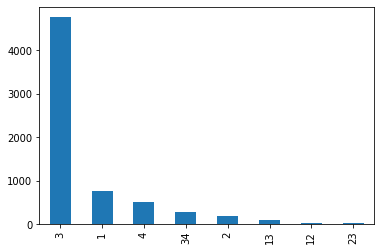

In [21]:
# count the instances of every defect type
train.ClassId.value_counts().plot(kind='bar')

In [22]:
train.ClassId.value_counts()

3     4759
1      769
4      516
34     284
2      195
13      91
12      35
23      14
Name: ClassId, dtype: int64

#### as you can see above, we do have unbalanced data, in order to solve this issue, we are going to use one of the Over-sampling techniques called "SMOTE"

##  Synthetic Minority Over-sampling Technique (SMOTE)

In [23]:
X = train['image_matrix']
y = train['ClassId']

In [24]:
X = [img.flatten() for img in X]

In [25]:
sm = SMOTE(random_state=42,k_neighbors=5,n_jobs=-1)

X_res, y_res = sm.fit_sample(X, y)

In [26]:
d = {'3':2,
'1':0,
'4':3,
'34':7,
'2':1,
'13':5,
'12':4,
'23':6}

In [27]:
y_res = y_res.map(d)

In [28]:
welcome_back=[i.reshape(256,1600) for i in X_res]

In [29]:
len(welcome_back)

38072

In [30]:
y_res = [np.int64(x) for x in y_res]

In [31]:
y_res = np.array(y_res)

In [32]:
#y_res = y_res-1

In [33]:
type(y_res)

numpy.ndarray

In [34]:
len(y_res)

38072

In [35]:
y_res

array([0, 2, 0, ..., 3, 3, 3])

In [36]:
welcome_back= np.array(welcome_back)

# CNN binary classifier model 

In [37]:
# train test split 

X_train, X_test, y_train, y_test = train_test_split(welcome_back, y_res,
                                                    test_size=0.3, random_state=42, stratify=y_res, shuffle=True)

In [38]:
X_train.shape

(26650, 256, 1600)

In [39]:
X_train[0].shape

(256, 1600)

In [40]:
type(X_train)

numpy.ndarray

In [41]:
# Reshaping the images so it can be used in the CNN

X_train=X_train.reshape(-1,256,1600,1)

In [42]:
type(X_train)

numpy.ndarray

In [43]:
X_train.shape

(26650, 256, 1600, 1)

In [44]:
y_train.shape

(26650,)

In [45]:
X_test=X_test.reshape(-1,256,1600,1)

In [46]:
# instantiate the model
model = tf.keras.Sequential()

# creating convolution layers
model.add(Conv2D(32,kernel_size=(5,5),input_shape=X_train.shape[1:],kernel_regularizer=l2(0.0005),activation="relu",strides=(2, 2)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(5,5),kernel_regularizer=l2(0.0005),activation="relu",strides=(2, 2)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(128,kernel_size=(5,5),kernel_regularizer=l2(0.0005),activation="relu",strides=(2, 2)))
model.add(MaxPooling2D(pool_size=(2,2)))

# creating hidden layer
model.add(Flatten())
model.add(Dense(1000))
model.add(Dropout(0.25))
model.add(Activation("relu"))

model.add(Dense(8))
model.add(Activation("softmax"))

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 798, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 399, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 198, 64)       51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 99, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 48, 128)        204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 24, 128)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0

In [48]:
#compiling 

model.compile(optimizer='adam',
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

In [49]:
#fitting the model 

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=None,
    epochs=50,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=6),
             ModelCheckpoint(filepath='welcome_back.h5', monitor='val_loss', save_best_only=True)], 
    validation_split=0.2,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False)

Train on 21320 samples, validate on 5330 samples
Epoch 1/50
21320/21320 [==============================] - 1259s 59ms/sample - loss: 1.9591 - accuracy: 0.4438 - val_loss: 1.3348 - val_accuracy: 0.5064
Epoch 2/50
21320/21320 [==============================] - 1252s 59ms/sample - loss: 1.1207 - accuracy: 0.5807 - val_loss: 1.0829 - val_accuracy: 0.6045
Epoch 3/50
21320/21320 [==============================] - 1270s 60ms/sample - loss: 0.8932 - accuracy: 0.6816 - val_loss: 0.8215 - val_accuracy: 0.7060
Epoch 4/50
21320/21320 [==============================] - 1253s 59ms/sample - loss: 0.7445 - accuracy: 0.7435 - val_loss: 0.7767 - val_accuracy: 0.7488
Epoch 5/50
21320/21320 [==============================] - 1240s 58ms/sample - loss: 0.6383 - accuracy: 0.7961 - val_loss: 0.6808 - val_accuracy: 0.7841
Epoch 6/50
21320/21320 [==============================] - 1242s 58ms/sample - loss: 0.4957 - accuracy: 0.8514 - val_loss: 0.6424 - val_accuracy: 0.8268
Epoch 7/50
21320/21320 [===============

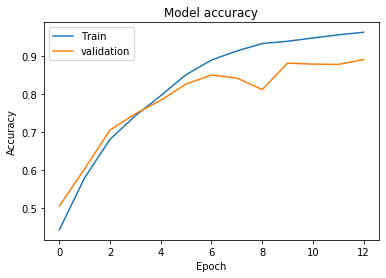

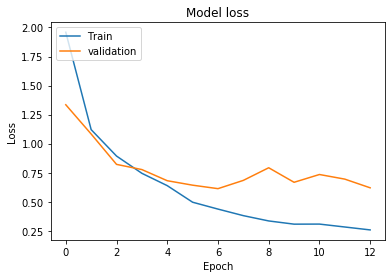

In [53]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

In [52]:
# Testing score (testing data 20%)

score = model.evaluate(X_test,y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
print("%s: %.2f%%" % (model.metrics_names[0], score[0]))

accuracy: 89.21%
loss: 0.64%


# import the model ( to save time )

### place the "welcome_back.h5" file in same directory of this sheet to save time 

In [ ]:
#model= tf.keras.models.load_model('welcome_back.h5')

In [ ]:
#model.summary()

In [ ]:
# score = model.evaluate(X_test,y_test, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
# print("%s: %.2f%%" % (model.metrics_names[0], score[0]))